In [79]:
######---INIT---###### 
import jax.numpy as jnp
import jax.random as random
from jax import grad, jit, value_and_grad
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import time


# F(X): generate_data
# Input(s): batch_no (number of batches), batch_size (size of each batch), rng_key (Jax RNG key)
# Output(s): x (3D vectors), y (normalised vectors on unit sphere), rng_key (updated RNG key)
def generate_data(batch_no, batch_size, rng_key):
    rng_key, subkey = random.split(rng_key)
    x = random.normal(subkey, (batch_no * batch_size, 3))
    radius = jnp.sqrt(jnp.sum(jnp.square(x), axis=-1, keepdims=True))
    y = x / radius
    return x, y, rng_key
    

In [63]:
# CLASS: FullyConnectedNN
# Input(s): layer_dims (list specifying dimensions of each layer)
# Output(s): None (initializes network layers)
class FullyConnectedNN(nn.Module):
    layer_dims: list

    def setup(self):
        self.layers = [nn.Dense(dim) for dim in self.layer_dims[1:]]

    # F(X): __call__
    # Input(s): x (input data)
    # Output(s): x (output of network after x passes through all layers)
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = nn.relu(layer(x))
        x = self.layers[-1](x)
        return x

# F(X): init_fully_connected_nn
# Input(s): layer_dims (list specifying dimensions of each layer), rng (RNG key)
# Output(s): model (initialised FCNN model), params (initialized model parameters), rng (updated RNG key)
def init_fully_connected_nn(layer_dims, rng):
    model = FullyConnectedNN(layer_dims)
    params = model.init(rng, jnp.ones([1, layer_dims[0]]))['params']
    return model, params, rng



In [72]:
# F(X): compute_loss
# Input(s): params (model parameters), model (FCNN model), x (input data), y (target data)
# Output(s): loss (MSE b/w predictions and targets), predictions (model predictions)
def compute_loss(params, model, x, y):
    predictions = model.apply({'params': params}, x)
    loss = jnp.mean(jnp.square(y - predictions))
    return loss, predictions



# F(X): train_network
# Input(s): x_train (training data), y_train (training targets), x_val (validation data), y_val (validation targets), 
#           params (model parameters), model (FCNN model), batch_size (samples per batch), 
#           num_epochs (number of training epochs), optimizer (optimizer instance)
# Output(s):params (updated model parameters), train_loss_history (training loss over epochs), 
#           val_loss_history (validation loss over epochs)
def train_network(x_train, y_train, x_val, y_val, params, model, batch_size, num_epochs, optimizer):
    opt_state = optimizer.init(params)
    train_loss_history = []
    val_loss_history = []

    @jit
    def step(params, opt_state, x, y):
        (loss, aux), grads = value_and_grad(compute_loss, has_aux=True)(params, model, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, aux

    num_samples = x_train.shape[0]
    for epoch in range(num_epochs):
        epoch_train_loss = 0
        for i in range(0, num_samples, batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            params, opt_state, loss, aux = step(params, opt_state, x_batch, y_batch)
            epoch_train_loss += loss
        epoch_train_loss /= (num_samples // batch_size)
        train_loss_history.append(epoch_train_loss)
        
        val_loss, _ = compute_loss(params, model, x_val, y_val)
        val_loss_history.append(val_loss)
        
        print(f"Epoch {epoch}, Training Loss: {epoch_train_loss}, Validation Loss: {val_loss}")

    return params, train_loss_history, val_loss_history



In [75]:
# F(X): evaluate_model (diagnostics)
# Input(s): params (model parameters), model (FCNN model), x_test (test data), y_test (test targets), 
#           train_loss_history (training loss over epochs), val_loss_history (validation loss over epochs)
# Output(s):y_pred (predicted outputs)
def evaluate_model(params, model, x_test, y_test, train_loss_history, val_loss_history):
    _, y_pred = compute_loss(params, model, x_test, y_test)
    test_loss, _ = compute_loss(params, model, x_test, y_test)
    print('Final training loss:', train_loss_history[-1], 'Test loss:', test_loss)

    fig = plt.figure(figsize=(12, 22))

    ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax.scatter(y_test[:, 0], y_test[:, 1], y_test[:, 2], c=y_test[:, 0], marker='.')
    plt.title("Training Data Targets")

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], c=y_pred[:, 0], marker='.')
    plt.title('Test Output Data')

    ax = fig.add_subplot(2, 2, 3)
    ax.plot(train_loss_history, label='Training Loss', marker='o')
    ax.plot(val_loss_history, label='Validation Loss', marker='o')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.legend()
    plt.show()

    return y_pred



Epoch 0, Training Loss: 0.15120108425617218, Validation Loss: 0.05604415759444237
Epoch 1, Training Loss: 0.043234966695308685, Validation Loss: 0.03632650151848793
Epoch 2, Training Loss: 0.029668742790818214, Validation Loss: 0.025748278945684433
Epoch 3, Training Loss: 0.019835053011775017, Validation Loss: 0.017304429784417152
Epoch 4, Training Loss: 0.01331772468984127, Validation Loss: 0.012326965108513832
Epoch 5, Training Loss: 0.009482893161475658, Validation Loss: 0.009278311394155025
Epoch 6, Training Loss: 0.0073067136108875275, Validation Loss: 0.007434795144945383
Epoch 7, Training Loss: 0.006053572054952383, Validation Loss: 0.006307652685791254
Epoch 8, Training Loss: 0.005250450223684311, Validation Loss: 0.0055403332225978374
Epoch 9, Training Loss: 0.004678026307374239, Validation Loss: 0.004974358715116978
Epoch 10, Training Loss: 0.004252132959663868, Validation Loss: 0.004542855080217123
Epoch 0, Training Loss: 0.004003456793725491, Validation Loss: 0.004035297781

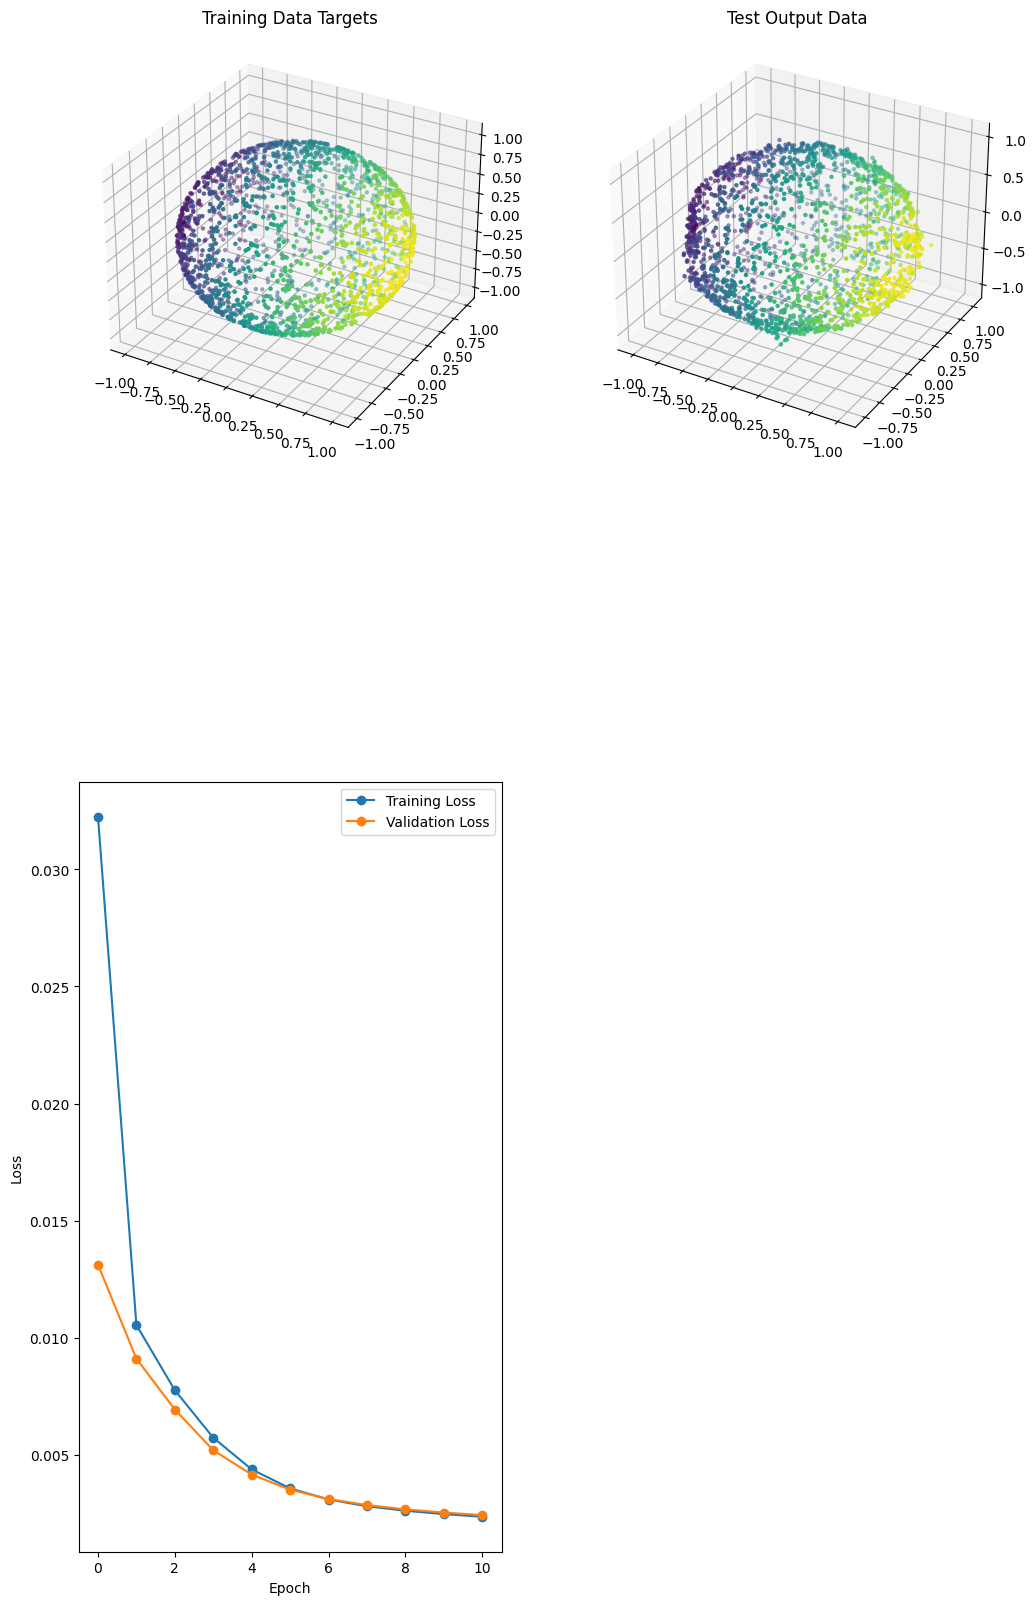

In [80]:
# F(X): main
# Input(s): batch_size (number of samples per batch), total_samples (total number of samples), 
#           epoch_count (number of training epochs), layer_dims (list of layer dimensions), 
#           k_folds (number of fold for cross-validation)
# Output(s):y_pred (predicted outputs)
def main(batch_size, total_samples, epoch_count, layer_dims, k_folds=5):
    rng_key = random.PRNGKey(2)
    model, params, rng_key = init_fully_connected_nn(layer_dims, rng_key)

    x, y, rng_key = generate_data(total_samples // batch_size, batch_size, rng_key)
    
    optimizer = optax.adam(learning_rate=0.001)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    all_train_loss_histories = []
    all_val_loss_histories = []

    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        x_train = x_train.reshape(-1, 3)
        y_train = y_train.reshape(-1, 3)
        x_val = x_val.reshape(-1, 3)
        y_val = y_val.reshape(-1, 3)

        params, train_loss_history, val_loss_history = train_network(x_train, y_train, x_val, y_val, params, model, batch_size, epoch_count, optimizer)

        all_train_loss_histories.append(train_loss_history)
        all_val_loss_histories.append(val_loss_history)

    # Averaging the loss histories over all folds
    avg_train_loss_history = jnp.mean(jnp.array(all_train_loss_histories), axis=0)
    avg_val_loss_history = jnp.mean(jnp.array(all_val_loss_histories), axis=0)

    y_pred = evaluate_model(params, model, x_val, y_val, avg_train_loss_history, avg_val_loss_history)
    return y_pred

# Execute Main Function
y_pred = main(batch_size=50, total_samples=10000, epoch_count=11, layer_dims=[3, 20, 20, 3])

Epoch 0, Training Loss: 0.15120108425617218, Validation Loss: 0.05604415759444237
Epoch 1, Training Loss: 0.043234966695308685, Validation Loss: 0.03632650151848793
Epoch 2, Training Loss: 0.029668742790818214, Validation Loss: 0.025748278945684433
Epoch 3, Training Loss: 0.019835053011775017, Validation Loss: 0.017304429784417152
Epoch 4, Training Loss: 0.01331772468984127, Validation Loss: 0.012326965108513832
Epoch 5, Training Loss: 0.009482893161475658, Validation Loss: 0.009278311394155025
Epoch 6, Training Loss: 0.0073067136108875275, Validation Loss: 0.007434795144945383
Epoch 7, Training Loss: 0.006053572054952383, Validation Loss: 0.006307652685791254
Epoch 8, Training Loss: 0.005250450223684311, Validation Loss: 0.0055403332225978374
Epoch 9, Training Loss: 0.004678026307374239, Validation Loss: 0.004974358715116978
Epoch 10, Training Loss: 0.004252132959663868, Validation Loss: 0.004542855080217123
Epoch 0, Training Loss: 0.004003456793725491, Validation Loss: 0.004035297781

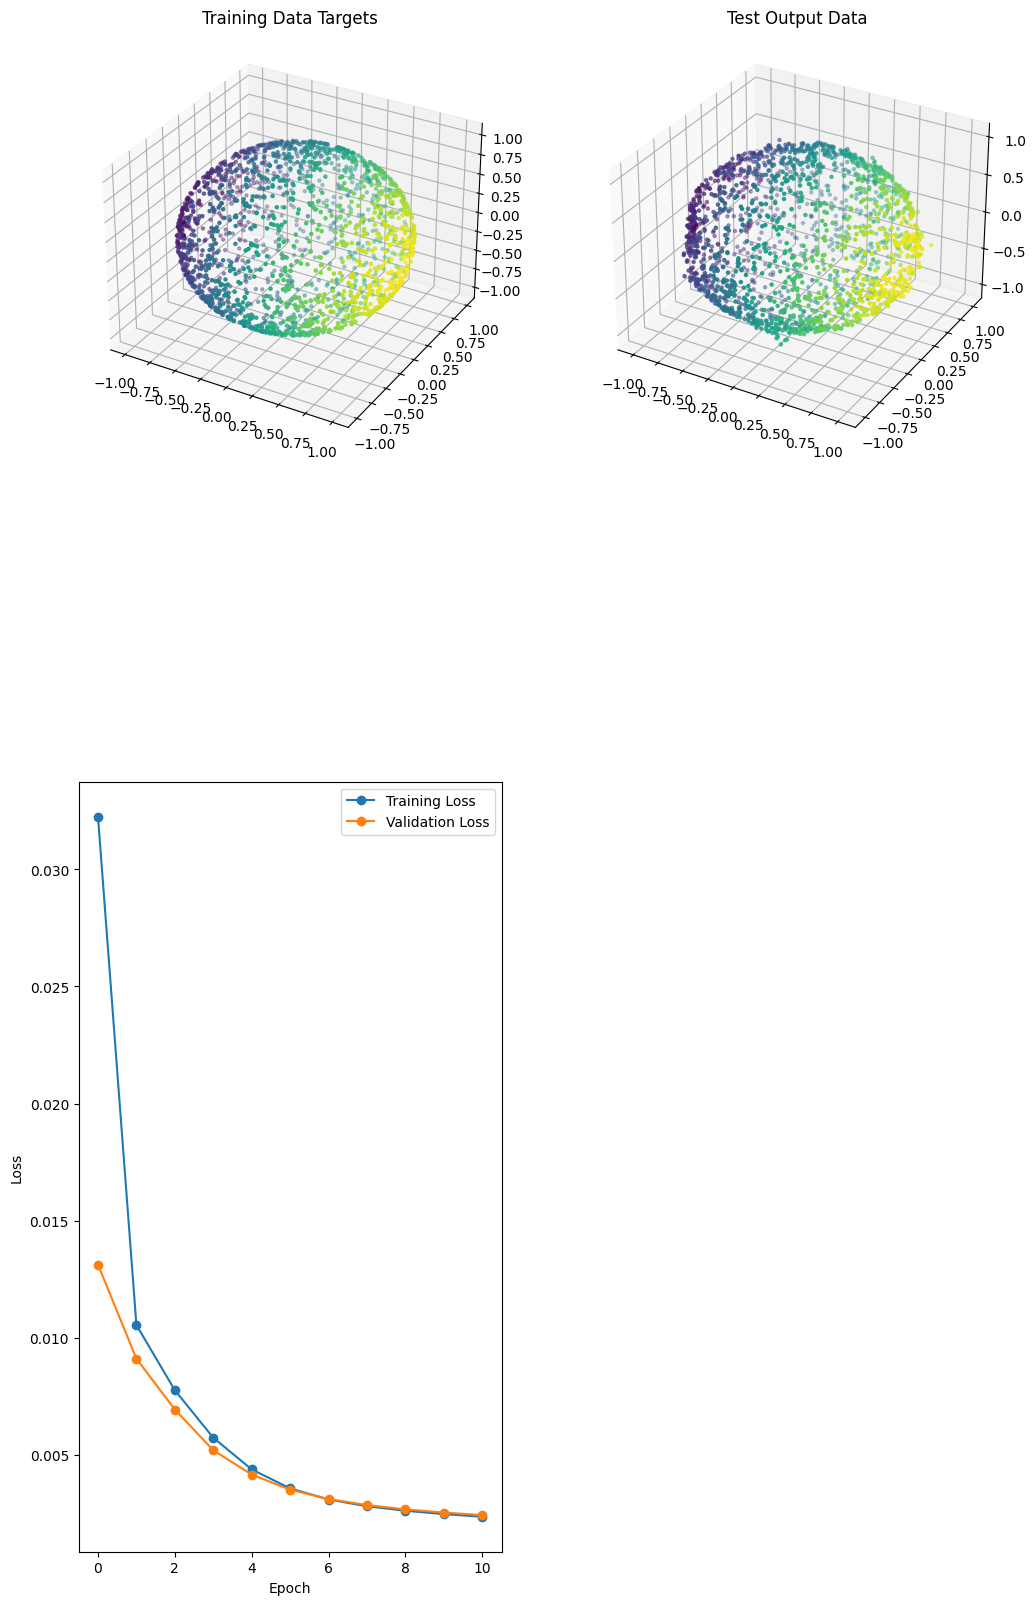

Execution time: 2.46 seconds


In [81]:
######---EXE---###### 
start_time = time.time()
y_pred = main(batch_size=50, total_samples=10000, epoch_count=11, layer_dims=[3, 20, 20, 3])
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

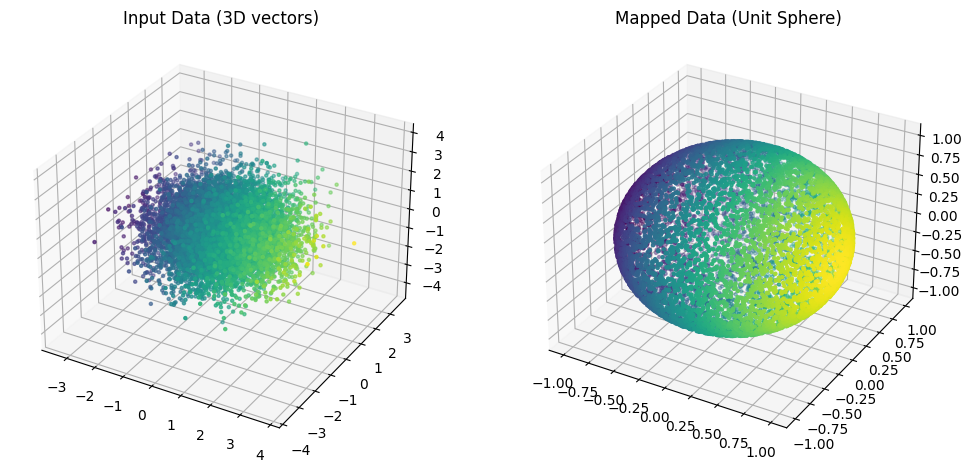

In [55]:
# Function to generate data
def generate_data(batch_no, batch_size, rng_key):
    rng_key, subkey = random.split(rng_key)
    x = random.normal(subkey, (batch_no * batch_size, 3))
    radius = jnp.sqrt(jnp.sum(jnp.square(x), axis=-1, keepdims=True))
    y = x / radius
    return x, y, rng_key

# Initialize RNG key
rng_key = random.PRNGKey(2)

# Generate training data (201 batches, 50 samples each)
x, y, rng_key = generate_data(201, 50, rng_key)

# Visualize the data before training
fig = plt.figure(figsize=(12, 6))

# Plot raw input data (before mapping to the sphere)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=x[:, 0], marker='.')
plt.title("Input Data (3D vectors)")

# Plot data after mapping to the sphere
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(y[:, 0], y[:, 1], y[:, 2], c=y[:, 0], marker='.')
plt.title("Mapped Data (Unit Sphere)")

plt.show()

Epoch 0, Training Loss: 0.00884266383945942, Validation Loss: 0.008471115492284298
Final training loss: 0.008842664 Test loss: 0.0084711155


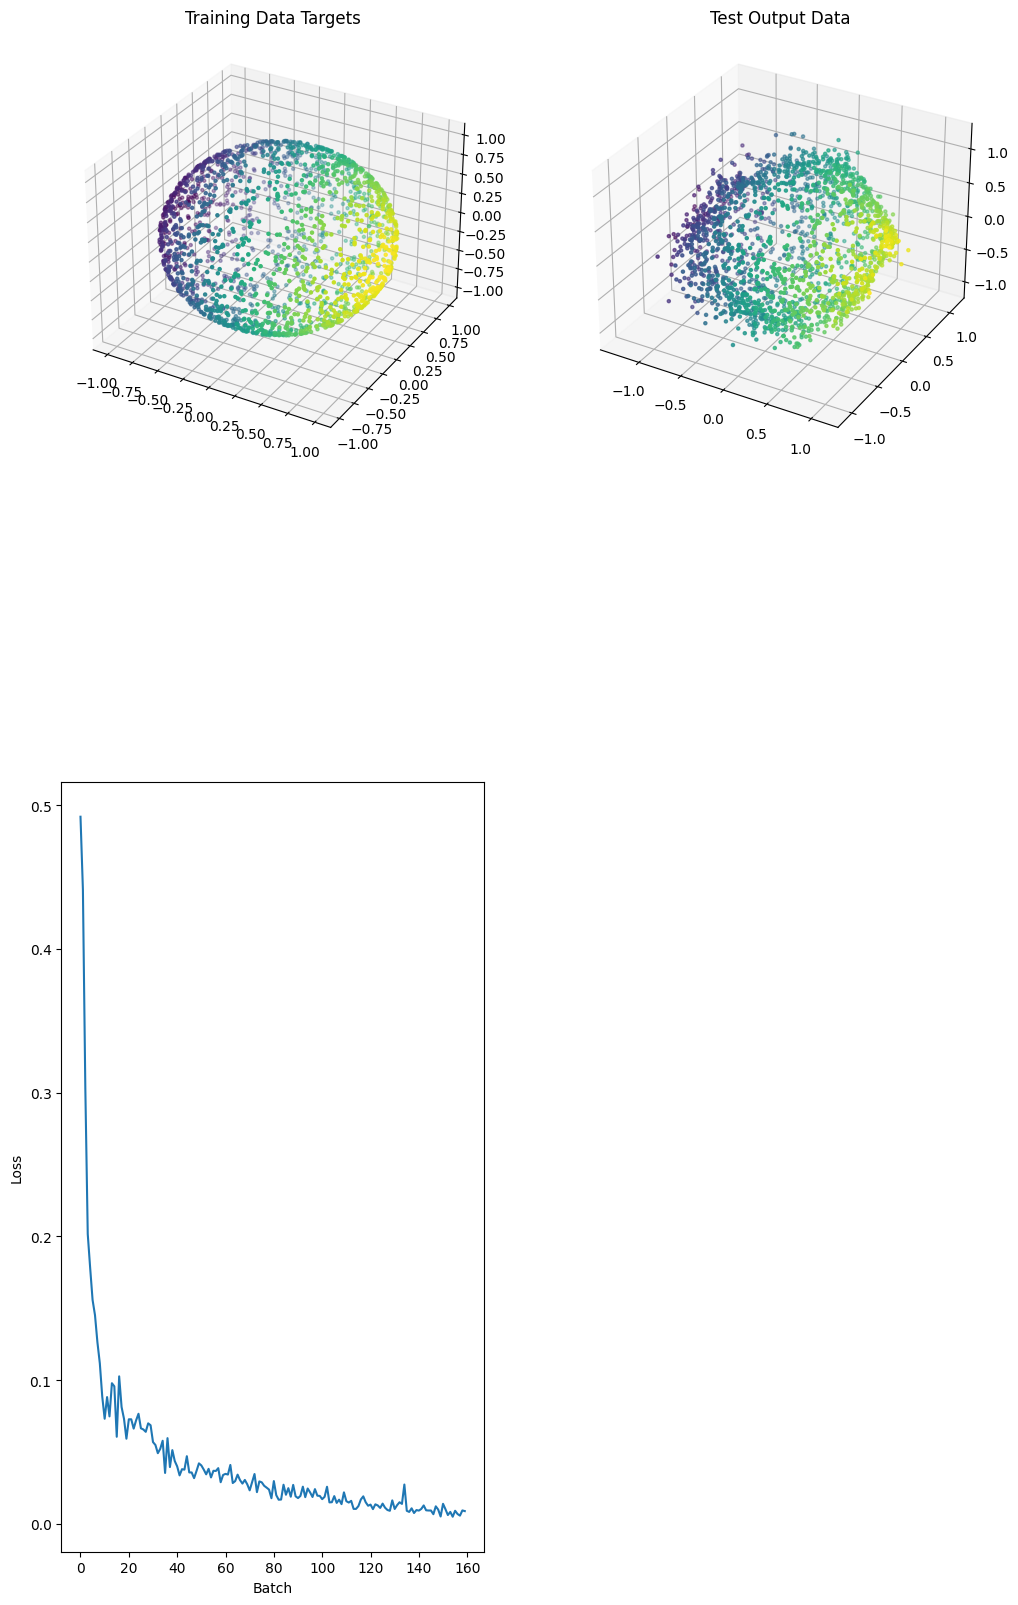

In [61]:
# OLD:: NO VALIDATION
# *** DO NOT MARK ***

import jax.numpy as jnp
import jax.random as random
from jax import grad, jit, value_and_grad
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
from functools import partial
import plotly.graph_objects as go

def generate_data(batch_no, batch_size, rng_key):
    rng_key, subkey = random.split(rng_key)
    x = random.normal(subkey, (batch_no, batch_size, 3))
    radius = jnp.sqrt(jnp.sum(jnp.square(x), axis=-1, keepdims=True))
    y = x / radius
    return x, y, rng_key

class FullyConnectedNN(nn.Module):
    layer_dims: list

    def setup(self):
        self.layers = [nn.Dense(dim) for dim in self.layer_dims[1:]]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = nn.relu(layer(x))
        x = self.layers[-1](x)
        return x

def init_fully_connected_nn(layer_dims, rng):
    model = FullyConnectedNN(layer_dims)
    params = model.init(rng, jnp.ones([1, layer_dims[0]]))['params']
    return model, params, rng

def compute_loss(params, model, x, y):
    predictions = model.apply({'params': params}, x)
    loss = jnp.mean(jnp.square(y - predictions))
    return loss, predictions

def train_network(x_train, y_train, x_val, y_val, params, model, batch_size, num_epochs, optimizer):
    opt_state = optimizer.init(params)
    train_loss_history = []
    val_loss_history = []

    @jit
    def step(params, opt_state, x, y):
        (loss, aux), grads = value_and_grad(compute_loss, has_aux=True)(params, model, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, aux

    num_samples = x_train.shape[0]
    for epoch in range(num_epochs):
        for i in range(0, num_samples, batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            params, opt_state, loss, aux = step(params, opt_state, x_batch, y_batch)
            train_loss_history.append(loss)

        val_loss, _ = compute_loss(params, model, x_val, y_val)
        val_loss_history.append(val_loss)
        
        print(f"Epoch {epoch}, Training Loss: {loss}, Validation Loss: {val_loss}")

    return params, train_loss_history, val_loss_history

def evaluate_model(params, model, x_test, y_test, loss_history):
    _, y_pred = compute_loss(params, model, x_test, y_test)
    test_loss, _ = compute_loss(params, model, x_test, y_test)
    print('Final training loss:', loss_history[-1], 'Test loss:', test_loss)

    fig = plt.figure(figsize=(12, 22))

    ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax.scatter(y_test[:, 0], y_test[:, 1], y_test[:, 2], c=y_test[:, 0], marker='.')
    plt.title("Training Data Targets")

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], c=y_pred[:, 0], marker='.')
    plt.title('Test Output Data')

    ax = fig.add_subplot(2, 2, 3)
    ax.plot(loss_history)
    ax.set_xlabel('Batch')
    ax.set_ylabel('Loss')
    plt.show()
    
    return y_pred

def main(batch_size, batch_count, epoch_count, layer_dims):
    rng_key = random.PRNGKey(2)
    model, params, rng_key = init_fully_connected_nn(layer_dims, rng_key)

    x, y, rng_key = generate_data(batch_count, batch_size, rng_key)
    train_ratio = 0.8
    num_train_samples = int(train_ratio * batch_count)

    x_train = x[:num_train_samples].reshape(-1, 3)
    y_train = y[:num_train_samples].reshape(-1, 3)
    x_val = x[num_train_samples:].reshape(-1, 3)
    y_val = y[num_train_samples:].reshape(-1, 3)

    optimizer = optax.adam(learning_rate=0.01)
    params, train_loss_history, val_loss_history = train_network(x_train, y_train, x_val, y_val, params, model, batch_size, epoch_count, optimizer)

    y_pred = evaluate_model(params, model, x_val, y_val, train_loss_history)
    return y_pred

# Execute Main Function
y_pred = main(batch_size=50, batch_count=201, epoch_count=1, layer_dims=[3, 20, 20, 3])
